## Interpretation Attempt - Association between gene expression and subtype or grade
### (Brain Lower Grade Glioma) 

This whole analysis showing that we could looking at gene one by one, and we need to assign genes into different groups or clusters. There are totally three methods I could think of that could be taken into considerations.

**Method 1: Non-negative matrix factorization**

**Method 2: Correlation matrix**

**Method 3: NLP**

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

## Gene Data Preprocessing

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,8.7141,36.4493,11.8131,8.6116,0.000,5.3382,3.7845,8.3071,...,19.1299,12.5770,10.9796,7.8225,3.3371,5.4526,8.2616,11.5121,5.3895,9.9433
2,UBE2Q2P2,100134869,22.7523,21.1767,11.0242,5.0835,30.261,27.8886,8.7230,15.4466,...,21.9905,27.0125,14.2608,16.6975,10.2310,16.1890,19.7074,18.7291,8.9103,7.4480


In [3]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail(3)

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [5]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: False
There are 307 columns with the same value.
[136542, 317712, 728045, 728036, 255313, 728096, 728062, 653282, 728042, 57135]...


In [6]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)

## Clinical Patient Data Preprocessing

In [7]:
## read patient data and preprocessing...
raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

## Creating anndata with sample as its obs:

In [8]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [9]:
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

## TCGA researchers learned about lower grade glioma?

Reference: https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/glioma

Mutations and chromosomal alterations define three lower grade glioma subtypes with distinct clinical outcomes: 

1. IDH mutant and 1p/19q co-deletion:

* The 1p/19q abnormality consists of deletion of a short arm of chromosome 1 and longer arm of chromosome 19.

* Mutations in IDH1 and IDH2, isocitrate dehydrogenases, lead to abnormal enzyme activity, hypermethylation, and deviant gene expression.

* This subtype is associated with the most favorable prognosis.

2. IDH mutant without 1p/19q co-deletion, associated with intermediate prognosis



3. IDH wild-type, associated with the poorest outcomes

IDH wild-type subtype shares genomic markers and similar clinical outcomes with glioblastomas, indicating that this subtype of lower grade glioma may be a precursor to the more aggressive counterpart.


Molecular signatures and subtypes may inform the classification, diagnosis, and treatment of lower grade gliomas:

* Lower grade gliomas without IDH mutations may benefit from treatment with protocols adapted from current glioblastoma treatments.

* Recently developed therapies may target the aberrant activity of IDH1/2 proteins in lower grade glioma.


In [10]:
gene_symbol_id.loc[(gene_symbol_id.Hugo_Symbol == "IDH1") | (gene_symbol_id.Hugo_Symbol == "IDH2")]

,Hugo_Symbol,Entrez_Gene_Id
8233,IDH1,3417
8234,IDH2,3418


## Association between glioma subtype and gene expression? 

**Summary:**  

According to following models, we found that gene expression level would have highly correlation with the subtype of Brain Lower Grade Glioma. We could predict the subtype of BLGG based on the level of expression. 

In [11]:
# preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

In [12]:
df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

In [13]:
# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [15]:
print(f"There are totally {len(X_test)} samples in test set.")

There are totally 127 samples in test set.


In [68]:
# using random forest classifier as the predicting model: 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(warm_start = True, n_estimators = 10)
rf.fit(X_train,y_train)
print(f"The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"The test set accuracy score: {rf.score(X_test,y_test)}")

The training set accuracy score: 1.0
The test set accuracy score: 0.9291338582677166


In [69]:
# F1-score, precision & recall 
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        64
           1       1.00      0.81      0.89        21
           2       1.00      0.88      0.94        42

    accuracy                           0.93       127
   macro avg       0.96      0.90      0.92       127
weighted avg       0.94      0.93      0.93       127



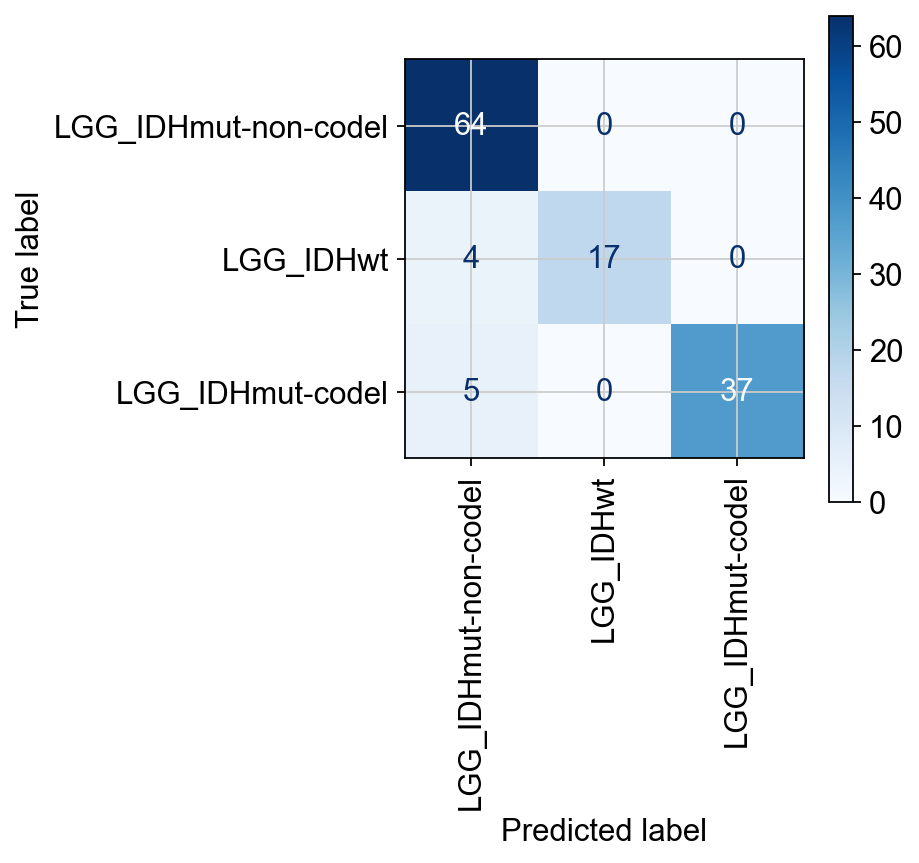

In [70]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

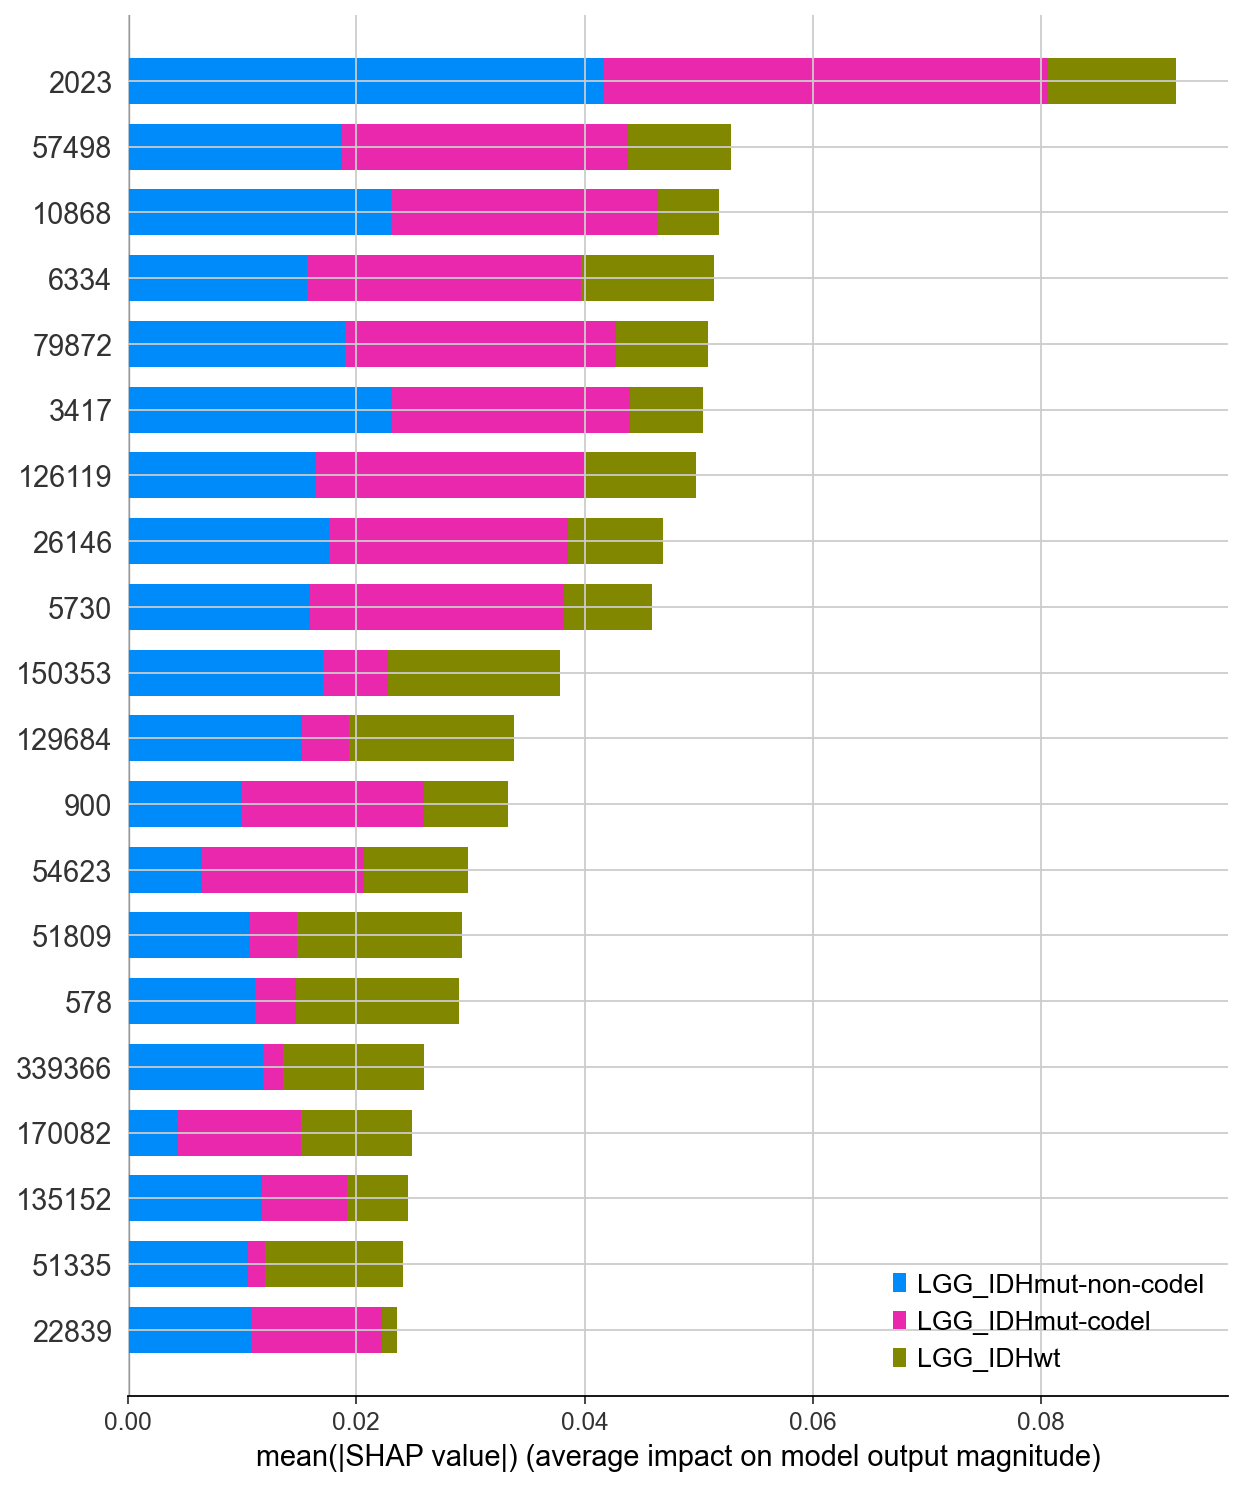

In [71]:
# feature importance inspection 
import shap 
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [20]:
feature_importance_nonzero = feature_importance.loc[feature_importance.feature_importance_vals >0]
print(f"!!!there are totally {len(feature_importance_nonzero)} genes that at least has some importance.")

!!!there are totally 1252 genes that at least has some importance.


In [21]:
feature_importance_nonzero

,gene_id,feature_importance_vals
0,5690,2.973386
1,390429,2.769244
2,1819,2.718330
3,51060,2.637901
4,55108,2.633682
...,...,...
1247,79728,0.010442
1248,89910,0.010344
1249,1366,0.009576
1250,26240,0.009545


## Due to every model would give different top rank genes, so I draw 50 times find the average ranking with low variance and high mentioned numbers:

In [72]:
def drawing():
    rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
    rf.fit(X_train,y_train)
    # print(f"The training set accuracy score: {rf.score(X_train,y_train)}")
    # print(f"The test set accuracy score: {rf.score(X_test,y_test)}")
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X)

    # get the table for feature_importance
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance = feature_importance.reset_index(drop=True)
    feature_importance_nonzero = feature_importance.loc[feature_importance.feature_importance_vals >0]
    return len(feature_importance_nonzero), feature_importance_nonzero.gene_id

nums = []
gene_important_draws = []
for e in range(50):
    num, gene_important = drawing()
    nums.append(num)
    gene_important_draws.append(gene_important)

In [23]:
gene_importance_mention_times = {}

for i in range(len(gene_important_draws)):
    for j in range(len(gene_important_draws[i])):
        if gene_important_draws[i][j] in gene_importance_mention_times:
            gene_importance_mention_times[gene_important_draws[i][j]] +=1
        else:
            gene_importance_mention_times[gene_important_draws[i][j]] = 1

In [24]:
df_gene_important = pd.DataFrame(gene_importance_mention_times.items())
df_gene_important.columns = ["gene_id", "times"]
df_gene_important = df_gene_important.sort_values("times", ascending =False)
df_gene_important["occur_ratio"] = df_gene_important["times"]/50
df_gene_important_more = df_gene_important[df_gene_important["occur_ratio"]>=0.20]
df_gene_important_more = df_gene_important_more.reset_index(drop = True)
df_gene_important_more

,gene_id,times,occur_ratio
0,10946,49,0.98
1,362,48,0.96
2,56181,47,0.94
3,148189,47,0.94
4,57212,47,0.94
...,...,...,...
1063,734,10,0.20
1064,145282,10,0.20
1065,90333,10,0.20
1066,150622,10,0.20


In [25]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_important_gene_description = df_gene_important_more.merge(df_gene_reference, how = "left", left_on = "gene_id", right_on = "NCBI GeneID")

# here is the table with the description:
df_important_gene_description.head(10)

,gene_id,times,occur_ratio,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,10946,49,0.98,10946.0,SF3A3,splicing factor 3a subunit 3,Homo sapiens,PROTEIN_CODING,10946.0,NCBI Ortholog
1,362,48,0.96,362.0,AQP5,aquaporin 5,Homo sapiens,PROTEIN_CODING,362.0,NCBI Ortholog
2,56181,47,0.94,56181.0,MTFR1L,mitochondrial fission regulator 1 like,Homo sapiens,PROTEIN_CODING,56181.0,NCBI Ortholog
3,148189,47,0.94,148189.0,LINC00662,long intergenic non-protein coding RNA 662,Homo sapiens,ncRNA,NaN,NaN
4,57212,47,0.94,57212.0,TP73-AS1,TP73 antisense RNA 1,Homo sapiens,ncRNA,57212.0,NCBI Ortholog
5,7268,46,0.92,7268.0,TTC4,tetratricopeptide repeat domain 4,Homo sapiens,PROTEIN_CODING,7268.0,NCBI Ortholog
6,65220,46,0.92,65220.0,NADK,NAD kinase,Homo sapiens,PROTEIN_CODING,65220.0,NCBI Ortholog
7,6429,45,0.90,6429.0,SRSF4,serine and arginine rich splicing factor 4,Homo sapiens,PROTEIN_CODING,6429.0,NCBI Ortholog
8,1819,45,0.90,1819.0,DRG2,developmentally regulated GTP binding protein 2,Homo sapiens,PROTEIN_CODING,1819.0,NCBI Ortholog
9,148479,45,0.90,148479.0,PHF13,PHD finger protein 13,Homo sapiens,PROTEIN_CODING,148479.0,NCBI Ortholog


In [26]:
df_important_gene_description.groupby("Gene Type").gene_id.count()

Gene Type
PROTEIN_CODING    1022
PSEUDO              18
ncRNA               26
Name: gene_id, dtype: int64

## Then what if we using left unimportant genes as features to do the prediction? 

In [27]:
non_important_genes = set(X.columns).difference(set(df_important_gene_description.gene_id))

X_non = X[non_important_genes]
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_non,y,random_state = 42)
rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
rf.fit(X_train,y_train)
print(f"The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"The test set accuracy score: {rf.score(X_test,y_test)}")
# it still have very high accuracy score, so I think we might could not looking at gene one by one, we might need to 
# cluster them or assign them into different groups. 

The training set accuracy score: 1.0
The test set accuracy score: 0.9763779527559056


### test with 1 random feature 

In [111]:
n = 1
X_train_rand = X_train.sample(n=1, axis=1)
X_train_rand

,90809
PATIENT_ID,
TCGA-EZ-7264,719.568970
TCGA-E1-5304,670.713013
TCGA-HT-7875,807.414978
TCGA-DU-8166,727.221008
TCGA-HW-7490,828.429993
...,...
TCGA-DU-7015,633.994995
TCGA-HT-7694,985.034973
TCGA-P5-A5EX,793.513977


In [112]:
rf = RandomForestClassifier()

In [113]:
rf.fit(X_train_rand, y_train)

RandomForestClassifier()

In [114]:
print(rf.score(X_train_rand, y_train))


1.0


**Notice**: It still have very high accuracy score. If there is no data leakage here, I think we might could not look at gene one by one, we might need to cluster them or assign them into different groups.

## Method 1: NMF

In [115]:
## see another notebook: 
## Main idea: could only use non-negative data, but with different level, so could I use max - min scale? 

## Method 2: Correlation Matrix - removing correlated genes

In [116]:
# remove the correlated genes and assign highly correlated gene into same group. 

## Method 3: using NLP to cluster genes according to its description, GO terms, and then use clusters as features

In [117]:
# Paper - r12 methods. 

## Emile: using Logistic with L1

In [118]:
from sklearn.linear_model import LogisticRegression

In [119]:
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_

In [120]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       1.00      0.90      0.95        21
           2       0.95      0.95      0.95        42

    accuracy                           0.96       127
   macro avg       0.97      0.95      0.96       127
weighted avg       0.96      0.96      0.96       127



In [121]:
print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

Train score 0.9736842105263158 
Test Score 0.9606299212598425


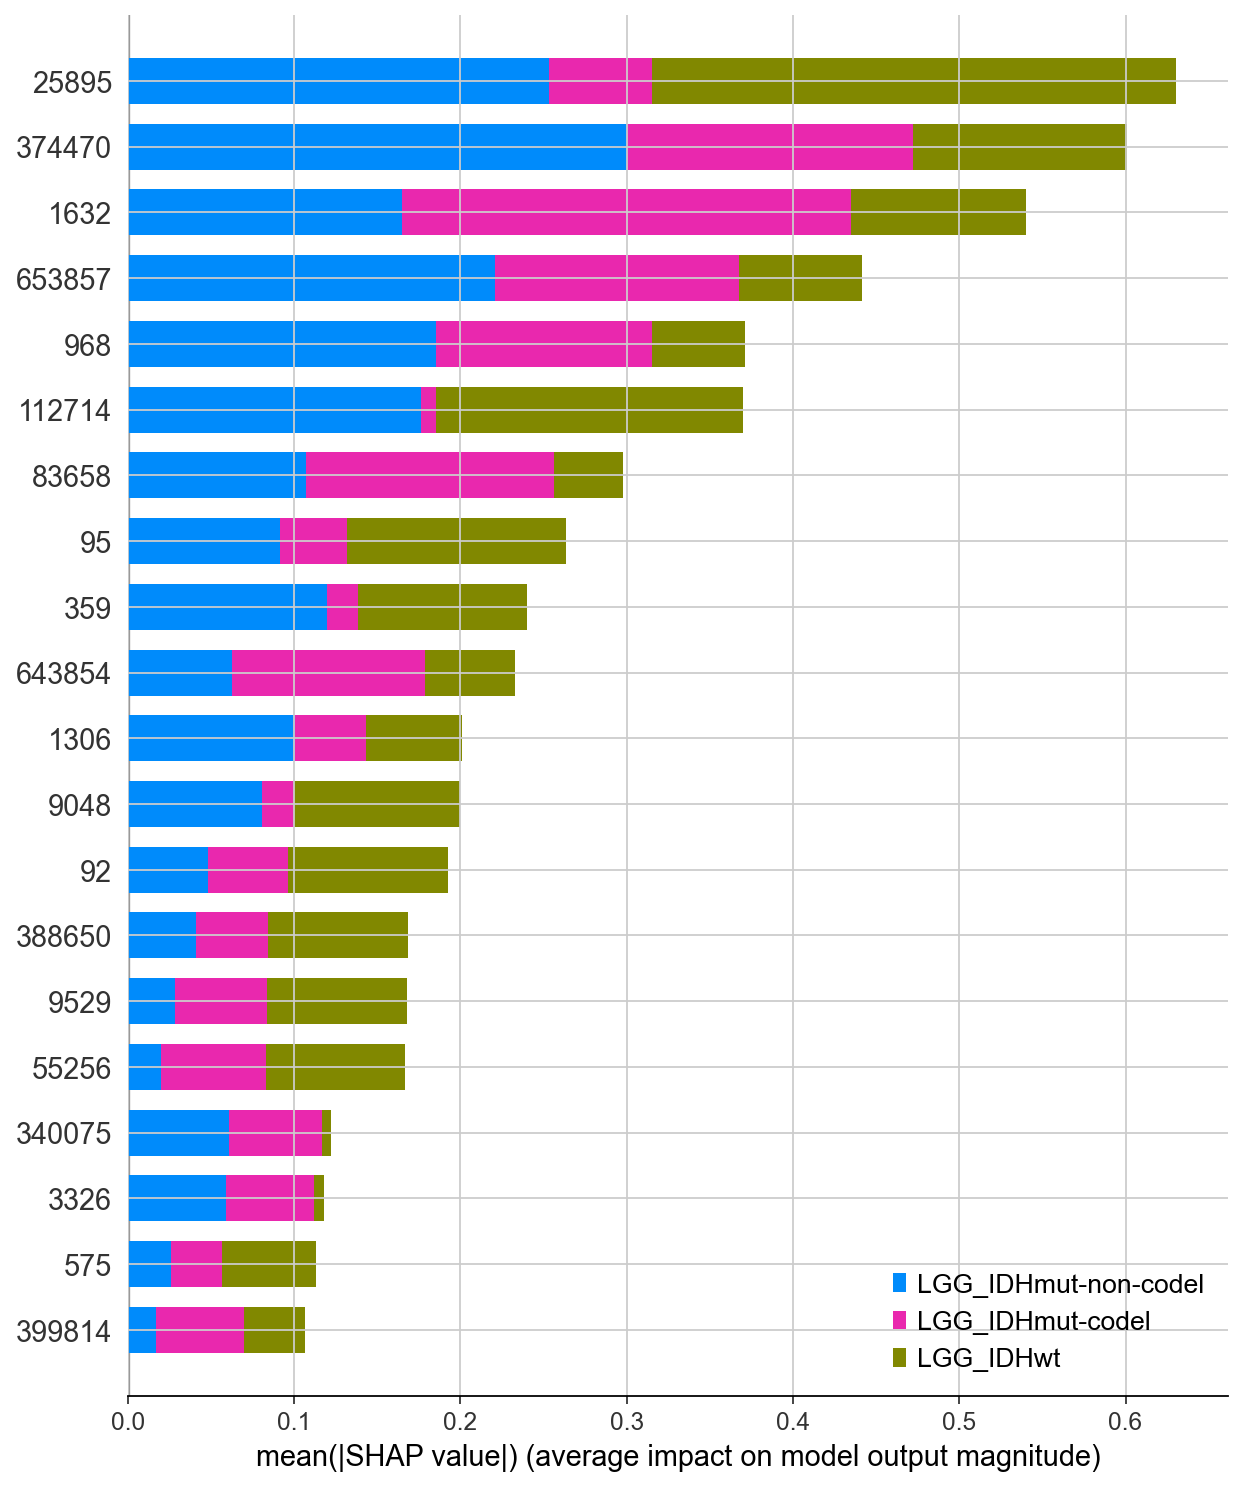

In [122]:
explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = X.columns)